### **Sivakumar M (20MIA1002) VELLORE INSTITUTE OF TECHNOLOGY - CHENNAI**

## **Objective:** To bulid a Multilingual Speech Recognition Model for RAG without Training

# Architecture

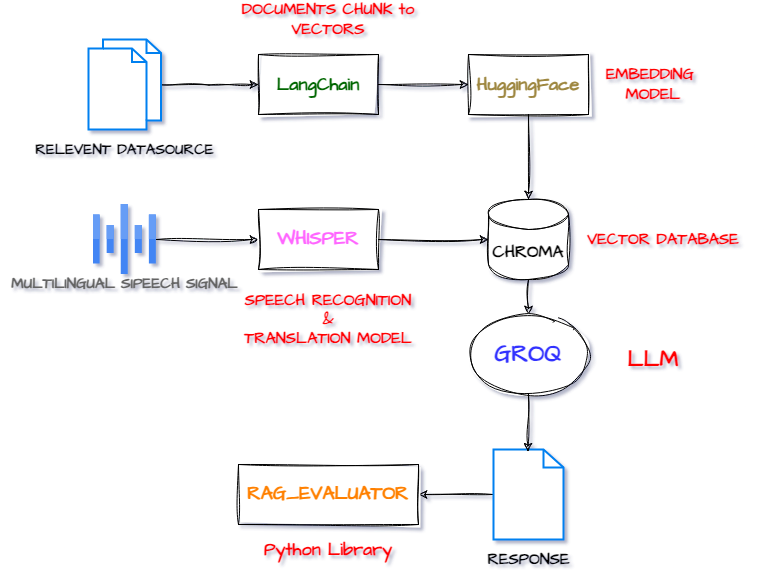

# Langchain Dependencies


In [ ]:
%pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-chroma langchain-groq sentence-transformers

langchain:
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

groq: 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

In [ ]:
import getpass
import os

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
os.environ["LANGCHAIN_API_KEY"] =  "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"

In [ ]:
# import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initializing LLM

In [ ]:
from groq import Groq
from langchain_groq import ChatGroq

llm = ChatGroq(temperature=0,
                      model_name="mixtral-8x7b-32768",
                      api_key= "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")

# Dataset Loading



In [ ]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import TextLoader # To use UnstructuredLoader
loader = DirectoryLoader("/content/", glob = "rag sample.txt", loader_cls = TextLoader)

In [ ]:
docs = loader.load() # returns "Contants" as String and "Metadata" as Dictionary

# Splitting

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index = True) # spliting to chunks
splits = text_splitter.split_documents(docs)


# Storing

In [ ]:
embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2", model_kwargs = {'device':'cpu'},encode_kwargs = {'normalize_embeddings': False})
vectorstore = Chroma.from_documents(documents=splits, embedding=embed_model)


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Retrieving

In [ ]:
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Multilingual Query

In [ ]:
!pip install transformers==4.40.0 accelerate datasets[audio]

In [ ]:
# !pip install git+https://github.com/huggingface/accelerate

In [ ]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
import accelerate

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

In [ ]:
model_id = "openai/whisper-large-v3"
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage = True, use_safetensors=True
)
model.to(device)
processor = AutoProcessor.from_pretrained(model_id)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)

In [ ]:
result_fr = pipe("/content/question french alonso.mp3",generate_kwargs={"task": "translate"})

In [ ]:
question_fr = result_fr["text"]

In [ ]:
question_fr # Translated Text

' Why did Alonso get fired?'

In [ ]:
response_fr = rag_chain.invoke(question_fr) # Retrieving the Generated Response from RAG

In [ ]:
response_fr # Response Text

"Alonso was fired from Marvel Studios in March 2023 due to breaching a 2018 agreement by working on an Amazon Studios film and refusing to comply with Disney's request to stop promoting it. This was reportedly due to a disagreement over censoring gay pride elements in a film for release in Kuwait. Disney and Alonso reached a compensation settlement in April 2023."

# Evaluation - French


In [ ]:
pip install rag-evaluator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.5 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=420d16bcee53b84fa5b2bc8bfa1d72b60d546fe79d4a14c062321719021b03da
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rag_evaluator import RAGEvaluator
evaluator = RAGEvaluator()

# Grouth Truth
reference_fr = "Alonso was fired from her role at Marvel Studios in March 2023 for serving as a producer on the Amazon Studios film Argentina, 1985 (2022), in breach of a 2018 agreement between Alonso and Disney to not work for a competing studio."

metrics_fr = evaluator.evaluate_all(question_fr, response_fr, reference_fr)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Failed to determine 'entailment' label id from the label2id mapping in the model config. Setting to -1. Define a descriptive label2id mapping in the model config to ensure correct outputs.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
for key, value in metrics_fr.items():
    print(f"{key}: {value}")

BLEU: 13.730349898168207
ROUGE-1: 0.49523809523809526
BERT P: 0.7589606046676636
BERT R: 0.7889101505279541
BERT F1: 0.7736456394195557
Perplexity: 53.02963638305664
Diversity: 0.967741935483871
Racial Bias: 0.49851536750793457


# Evaluation - German

In [ ]:
result_gr = pipe("/content/question german committe.mp3",generate_kwargs={"task": "translate"})

In [ ]:
question_gr = result_gr["text"]

In [ ]:
question_gr # Translated Text

' Who are the six members of the Marvel Committee?'

In [ ]:
response_gr = rag_chain.invoke(question_gr) # Retrieving the Generated Response from RAG

In [ ]:
response_gr # Response Text

"The six members of the Marvel Committee are Kevin Feige, Louis D'Esposito, Dan Buckley, Joe Quesada, Brian Michael Bendis, and Alan Fine. They were formed to preserve Marvel Studios' artistic integrity and oversee key film decisions. This committee was responsible for the shared narrative continuity of the films, known as the Marvel Cinematic Universe."

In [ ]:
# Grouth Truth
reference_gr = "Kevin Feige, Louis D'Esposito, Dan Buckley, Joe Quesada, Brian Michael Bendis, and Alan Fine who oversaw the committee."

metrics_gr = evaluator.evaluate_all(question_gr, response_gr, reference_gr)
for key, value in metrics_gr.items():
    print(f"{key}: {value}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BLEU: 29.46203162820921
ROUGE-1: 0.45945945945945943
BERT P: 0.7310687303543091
BERT R: 0.8672685623168945
BERT F1: 0.7933655977249146
Perplexity: 16.414562225341797
Diversity: 0.9444444444444444
Racial Bias: 0.482819139957428


# Evaluation - Hindi

In [ ]:
result_hin = pipe("/content/question hindi 2009.mp3",generate_kwargs={"task": "translate"})

In [ ]:
question_hin = result_hin["text"]

In [ ]:
question_hin # Translated Text

' Who bought Marvel in 2009?'

In [ ]:
response_hin = rag_chain.invoke(question_hin) # Retrieving the Generated Response from RAG

In [ ]:
response_hin # Response Text

'The context does not explicitly state that The Walt Disney Company bought Marvel in 2009, but it does mention that Disney purchased Marvel Entertainment for $4 billion in December 2009. Therefore, The Walt Disney Company bought Marvel Entertainment in December 2009.'

In [ ]:
# Grouth Truth
reference_hin = "In December 2009, the Walt Disney Company purchased Marvel Entertainment for $4 billion.."

metrics_hin = evaluator.evaluate_all(question_hin, response_hin, reference_hin)
for key, value in metrics_hin.items():
    print(f"{key}: {value}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BLEU: 17.412164273266505
ROUGE-1: 0.48148148148148145
BERT P: 0.7777749300003052
BERT R: 0.8450458645820618
BERT F1: 0.8100160360336304
Perplexity: 14.17299747467041
Diversity: 0.7804878048780488
Racial Bias: 0.47613993287086487


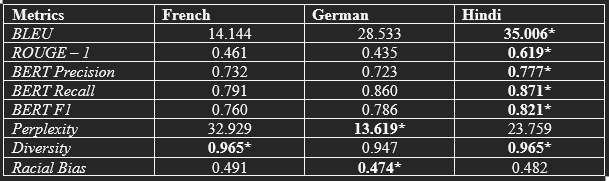